In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [3]:
# 一些超参数
learning_rate = 1e-3
# 如果有GPU，该脚本将使用GPU进行计算
device = 'cuda' if torch.cuda.is_available() else 'cpu'

感谢Wanghaha（xufengnian-bei）的贡献，如果在下载过程中遇到网络问题，请使用下面的步骤进行处理。

* 访问 Hugging Face 数据集页面: https://huggingface.co/datasets/code_search_net
* 在页面上找到 "Files and versions" 部分。
* 点击data文件夹，下载对应的python.zip

修改对应下载文件代码：

datasets = load_dataset('json', data_files='data/python/python/final/jsonl/train/*.jsonl.gz') # 更换为自己的目录
datasets = datasets['train'].filter(lambda x: 'apache/spark' in x['repo']) # 这里repository_name 更换为 repo

print(datasets[8]['original_string']) # whole_func_string 更换为 original_string

In [4]:
raw_datasets = load_dataset('code_search_net', 'python')
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

Filter:   0%|          | 0/412178 [00:00<?, ? examples/s]

In [5]:
class RNNCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden=None):
        # input:  (1, I),在NLP领域，I等于文本嵌入的C
        # hidden: (1, H)
        if hidden is None:
            hidden = self.init_hidden(input.device)
        combined = torch.concat((input, hidden), dim=-1)  # (1, I + H)
        hidden = F.relu(self.i2h(combined))               # (1,     H)
        return hidden

    def init_hidden(self, device):
        return torch.zeros((1, self.hidden_size), device=device)

In [6]:
r_model = RNNCell(2, 3)
data = torch.randn(4, 1, 2)
hidden = None

for i in range(data.shape[0]):
    hidden = r_model(data[i], hidden)
    print(hidden)

tensor([[0.0973, 0.0144, 0.0000]], grad_fn=<ReluBackward0>)
tensor([[0.0000, 0.0000, 0.4002]], grad_fn=<ReluBackward0>)
tensor([[0.0000, 0.3787, 0.0000]], grad_fn=<ReluBackward0>)
tensor([[0.0218, 0.1896, 0.0000]], grad_fn=<ReluBackward0>)


In [16]:
class CharRNN(nn.Module):

    def __init__(self, vs):
        super().__init__()
        self.emb = nn.Embedding(vs, 30)
        self.rnn = RNNCell(30, 50)
        self.lm = nn.Linear(50, vs)

    def forward(self, x, hidden=None):
        # x: (1)
        # hidden: (1, 50)
        embeddings = self.emb(x)      # (1, 30)
        hidden = self.rnn(embeddings, hidden)  # (1, 50)
        out = self.lm(hidden)         # (1, vs)
        return out, hidden

In [29]:
class CharTokenizer:

    def __init__(self, data, end_ind=0):
        # data: list[str]
        # 得到所有的字符
        chars = sorted(list(set(''.join(data))))
        #self.char2ind = {s: i + 2 for i, s in enumerate(chars)}
        self.char2ind = {s: i + 1 for i, s in enumerate(chars)}
        #self.char2ind['<|b|>'] = begin_ind
        self.char2ind['<|e|>'] = end_ind
        self.ind2char = {v: k for k, v in self.char2ind.items()}
        #self.begin_ind = begin_ind
        self.end_ind = end_ind

    def encode(self, x):
        # x: str
        return [self.char2ind[i] for i in x]

    def decode(self, x):
        # x: int or list[x]
        if isinstance(x, int):
            return self.ind2char[x]
        return [self.ind2char[i] for i in x]

In [30]:
tokenizer = CharTokenizer(datasets['whole_func_string'])
test_str = 'def f(x):'
re = tokenizer.encode(test_str)
print(re)
''.join(tokenizer.decode(range(len(tokenizer.char2ind))))

[70, 71, 72, 2, 72, 10, 90, 11, 28]


'<|e|>\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~ö'

In [31]:
c_model = CharRNN(len(tokenizer.char2ind)).to(device)

In [32]:
c_model

CharRNN(
  (emb): Embedding(98, 30)
  (rnn): RNNCell(
    (i2h): Linear(in_features=80, out_features=50, bias=True)
  )
  (lm): Linear(in_features=50, out_features=98, bias=True)
)

In [33]:
inputs = torch.tensor(tokenizer.encode('d'), device=device)
out, hidden = c_model(inputs)
out.shape, hidden.shape

(torch.Size([1, 98]), torch.Size([1, 50]))

In [34]:
@torch.no_grad()
def generate(model, idx, tokenizer, max_new_tokens=300):
    # idx: (1)
    out = idx.tolist()
    hidden = None
    model.eval()
    for _ in range(max_new_tokens):
        logits, hidden = model(idx, hidden)
        probs = F.softmax(logits, dim=-1)  # (1, 98)
        # 随机生成文本
        ix = torch.multinomial(probs, num_samples=1)  # (1, 1)
        ## 更新背景
        #context = torch.concat((context[:, 1:], ix), dim=-1)
        out.append(ix.item())
        idx = ix.squeeze(0)
        if out[-1] == tokenizer.end_ind:
            break
    model.train()
    return out

In [35]:
inputs = torch.tensor(tokenizer.encode('d'), device=device)
print(''.join(tokenizer.decode(generate(c_model, inputs, tokenizer))))

dpZ\[DTWFpe
"omF^3drBZ708qbyUl+bC71q^&GG%04$bm{og$OT+:A_ST49/EpBQro!&oJnJn9iU#53^<n7M H}8Qd<L,#vtrB/;**?Kx}m!s=<|e|>


In [36]:
def process(text, tokenizer):
    # text: str
    enc = tokenizer.encode(text)
    inputs = enc
    labels = enc[1:] + [tokenizer.end_ind]
    return torch.tensor(inputs, device=device), torch.tensor(labels, device=device)

In [38]:
process(test_str, tokenizer)

(tensor([70, 71, 72,  2, 72, 10, 90, 11, 28], device='cuda:0'),
 tensor([71, 72,  2, 72, 10, 90, 11, 28,  0], device='cuda:0'))

In [41]:
lossi = []
epochs = 1
optimizer = optim.Adam(c_model.parameters(), lr=learning_rate)

for e in range(epochs):
    for data in datasets:
        inputs, labels = process(data['whole_func_string'], tokenizer)
        hidden = None
        _loss = 0.0
        lens = len(inputs)
        for i in range(lens):
            logits, hidden = c_model(inputs[i].unsqueeze(0), hidden)
            _loss += F.cross_entropy(logits, labels[i].unsqueeze(0)) / lens
        lossi.append(_loss.item())
        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

In [42]:
inputs = torch.tensor(tokenizer.encode('d'), device=device)
print(''.join(tokenizer.decode(generate(c_model, inputs, tokenizer))))

dofUf_an(th  """
            sedCon)<|e|>


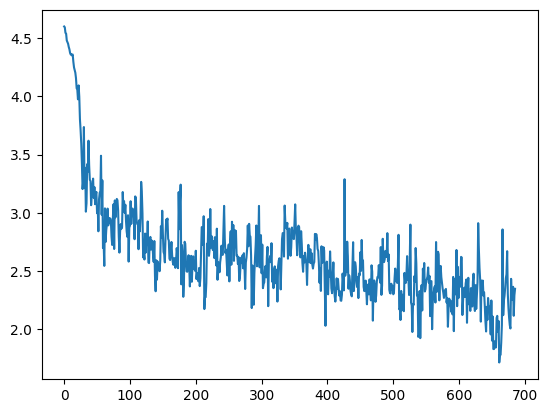

In [43]:
plt.plot(lossi)